## Example of network generation and dynamic simulation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import time

# modules specific to this project
import network as nw
import physics
import timemarching as tm
import plotter
import logger


### 1. Define the broadcasting channels of the network
This is done by creating a list of the channel names. The names are arbitrary and can be set by the user, such as 'postive', 'negative' or explicit wavelenghts like '870 nm', '700 nm'. Here I chose the colors 'red' and 'blue'.

In [2]:
channel_list = ['red', 'blue']
# Automatically generate the object that handles them
channels = {channel_list[v] : v for v in range(len(channel_list))}

### 2. Define the layers
Define the layers of nodes in terms of how they are connected to the channels. Layers and weights are organized in dictionaries. The input and output layers do not need to be changed, but for the hidden layer we need to specify the number of nodes N and assign the correct channels to the input/output of the node.

In [3]:
# Create layers ordered from 0 to P organized in a dictionary
layers = {} 
# An input layer automatically creates on node for each channel that we define
layers[0] = nw.InputLayer(input_channels=channels)
layers[1] = nw.HiddenLayer(N=1, output_channel='blue',excitation_channel='blue',inhibition_channel='red')
layers[2] = nw.HiddenLayer(N=2, output_channel='red', excitation_channel='blue',inhibition_channel='red')
layers[3] = nw.OutputLayer(output_channels=channels) # similar to input layer

### 3. Define existing connections between layers
The weights are set in two steps. 
First the connetions between layers are defined. This should be done using the keys defined for each layer above, i.e. 0, 1, 2 ... for input, hidden and output layers, respectively. The `connect_layers` function returns a weight matrix object that we store under a chosen key, for example `'inp->hid'`.
Second, the specific connections on the node-to-node level are specified using the node index in each layer

In [4]:
# Define the overall connectivity
weights = {}
# The syntax is connect_layers(from_layer, to_layer, layers, channels)
weights['inp->hd0'] = nw.connect_layers(0, 1, layers, channels)
weights['hd0->hd1'] = nw.connect_layers(1, 2, layers, channels)
weights['hd1->out'] = nw.connect_layers(2, 3, layers, channels)
# Recurrent connections possible
weights['hd1->hd1'] = nw.connect_layers(2, 2, layers, channels)

# Define the specific node-to-node connections in the weight matrices
# The syntax is connect_nodes(from_node, to_node, weight=value in weight matrix)

# Input to first hidden layer
weights['inp->hd0'].connect_nodes(channels['blue'] ,0, channel='blue', weight=2.0) # channels['blue']=1
weights['inp->hd0'].connect_nodes(channels['red'] ,0, channel='red', weight=4.0)   # channels['red']=0
# First to second hidden layer
weights['hd0->hd1'].connect_nodes(0 ,1, channel='blue', weight=0.5) 
weights['hd0->hd1'].connect_nodes(0 ,0, channel='blue', weight=2.0) 
# Recurrent connections in second hiden layer
weights['hd1->hd1'].connect_nodes(0, 1, channel='red', weight=1.0)
# Second hidden layer to output
weights['hd1->out'].connect_nodes(1, channels['red'], 'red', weight=0.1)

# We can also set the weights by a prescribed weight matrix per channel
W_blue = [[0.0, 0.0],
          [1.0, 1.0]]
weights['inp->hd1'] = nw.connect_layers(0, 2, layers, channels)
weights['inp->hd1'].set_W('blue',W_blue) 

# A procedure exists to print the weihgts channel-wise
weights['inp->hd1'].print_W()
# Blue channel only
print('Blue channel only:')
weights['inp->hd1'].print_W('blue')

# Reset those weights again
weights['inp->hd1'].set_W('blue',[[0,0],[0,0]]) 

red:
[[0. 0.]
 [0. 0.]]
blue:
[[0. 0.]
 [1. 1.]]
Blue channel only:
blue:
[[0. 0.]
 [1. 1.]]


### 4. Visualize the network 
The `plotter` module supplies functions to visualize the network structure. The nodes are named by the layer type (Input, Hidden (H,K,L...) or Output) and the index. 

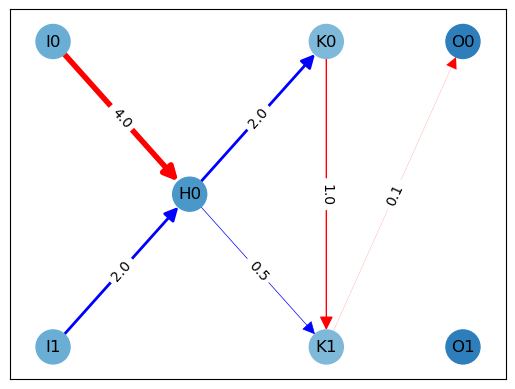

In [5]:
plotter.visualize_network(layers, weights)

### 5. Specify the physics of the nodes
Before running any simulations, we need to specify the input currents and the physics of the hidden layer nodes. Parameters can either be specified directly or coupled from the `physics` module. 

In [11]:
# Specify an exciting current square pulse and an inhibition square pulse
t_blue = [(0.5,0.6)] # a 100 ps pulse at 0.5 ns 
# and inhibition from the other one
t_red = [(0.7,0.78)] # a 80 ps pulse at 0.7 ns 

# Use the square pulse function and specify which node in the input layer gets which pulse
layers[0].set_input_func(channel='blue',func_handle=physics.square_pulse, func_args=t_blue)
layers[0].set_input_func(channel='red', func_handle=physics.square_pulse, func_args=t_red)

# Specify the internal dynamics by supplying the RC constants to the hidden layer (six parameters)
layers[1].set_gammas(physics.example_gammas())
layers[2].set_gammas(physics.example_gammas())

# Specify the transistor mapping Vgate on each node to the source-drain current Isd (function handle)
layers[1].func_Vgate_to_Isd = physics.transistorIV
layers[2].func_Vgate_to_Isd = physics.transistorIV

### 6. Example dynamic simulation

In [21]:
# Start time t, end time T
t = 0.0
T = 2.0 # ns
# To sample result over a fixed time-step, use savetime
savestep = 0.1
savetime = savestep
# These parameters are used to determine an appropriate time step each update
dtmax = 0.05 # ns 
dVmax = 0.01 # V

nw.reset(layers)
# Create a log over the dynamic data
time_log = logger.Logger(layers,channels) # might need some flags

start = time.time()

while t < T:
    # evolve by calculating derivatives, provides dt
    dt = tm.evolve(t, layers, dVmax, dtmax )

    # update with explicit Euler using dt
    tm.update(dt, t, layers, weights)
    
    t += dt
    # Log the progress
    if t > savetime :
        # Put log update here to have (more or less) fixed sample rate
        print(f'Time at t={t} ns') 
        savetime += savestep
    
    time_log.add_tstep(t, layers)

end = time.time()
print('Time used:',end-start)

# This is a large pandas data frame of all system variables
result = time_log.get_timelog()

Time at t=0.10001106407292878 ns
Time at t=0.20000151881824033 ns
Time at t=0.30000036735965663 ns
Time at t=0.4000000199928686 ns
Time at t=0.5000001418634786 ns
Time at t=0.6000000591648311 ns
Time at t=0.7000004095241601 ns
Time at t=0.8000000578308705 ns
Time at t=0.9000001240164127 ns
Time at t=1.000000338068816 ns
Time at t=1.1000004010052749 ns
Time at t=1.200000257936089 ns
Time at t=1.300000402591468 ns
Time at t=1.400000365554968 ns
Time at t=1.500000473308732 ns
Time at t=1.6000003885252514 ns
Time at t=1.7000002842737687 ns
Time at t=1.8000003358018346 ns
Time at t=1.9000006475202849 ns
Time at t=2.0000005752132055 ns
Time used: 512.0622370243073


### Visualize results using `plotter` module

Plot results for specific nodes

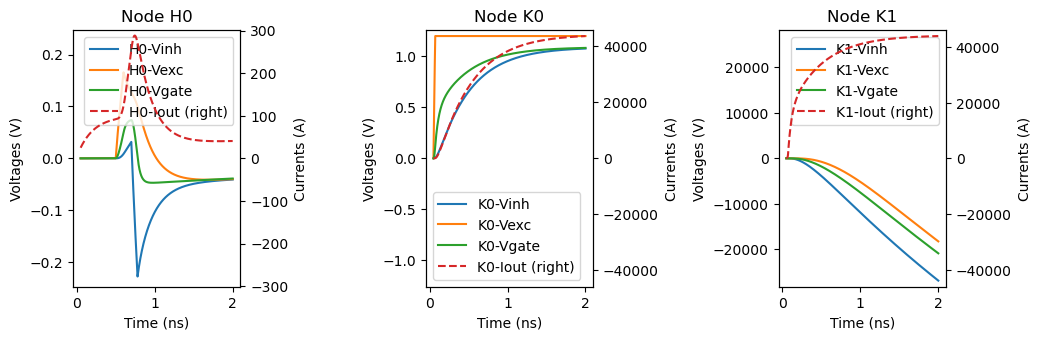

In [22]:
nodes = ['H0','K0','K1']
plotter.plot_nodes(result, nodes)

Plot results by choosing a number of attributes and get a plot comparing all nodes

In [ ]:
attr_list = ['Vgate','Vexc']
plotter.plot_attributes(result, attr_list)

We can also choose to plot along connected nodes, like from I0 to O0, here with Iout as the variable (Iout is the only variable that exists both in input, output and hidden layers).

In [ ]:
# Variable G contains a graph object descibing the network
G = plotter.retrieve_G(layers, weights)
plotter.plot_chainlist(result, G, 'I0','O0')

It is also possible to plot an explicit list of variables with the following function

In [ ]:
plotter.visualize_dynamic_result(result, ['H0-Vgate','H0-Vexc','K1-Vgate','K1-Vexc'])

### Vislualize model using `plotter` module

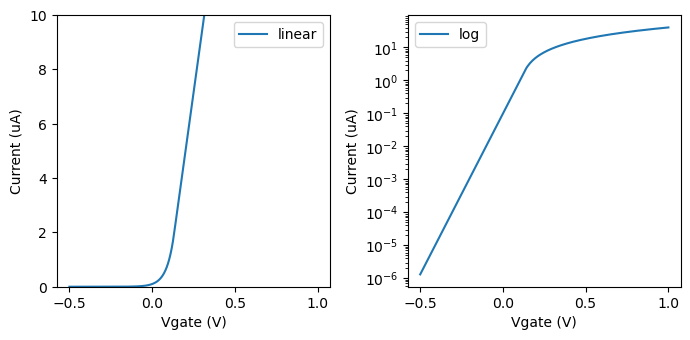

In [2]:
plotter.visualize_transistor(physics.transistorIV, physics.transistorIV_example())

### Calculate gain plots using system transfer function

In [12]:
# Setup the gain function
gammas = physics.example_gammas()
capacitances = physics.example_capacitances()
eigvals = physics.setup_gain(gammas)

# The eigenvalues
print('System eigenvalues:')
k=0
for l in eigvals :
    print(f'eig[{k}]={l:.2f} ns^-1 ')
    k+=1
# Regarding the eigenvalues, eig[0]=-25.81 ns^-1, eig[1]=-5.00 ns^-1, eig[2]=-0.19 ns^-1
# eig[1] regards the charge collecting subsystem, this is their RC constant
# eig[0] regards the exchange between the collectors and the storage, I believe. For A33=20 it's zero
# eig[2] regards the time scale of the storage unit, the longest timescale in the system.
    
# PUT THIS IN THE PLOTTER MODULE
import numpy as np
# Visualize the response function 
Ns = 100
# Units are already in GHz so this creates a space from 1 MHz to 10 GHz
s_exp = np.linspace(-3,1,Ns)
s = 1j*10**s_exp

# Sample the gain function
G11, _ = physics.gain(s,eigvals,gammas,capacitances)

mag_G11 = np.absolute(G11) / np.absolute(G11[0])
arg_G11 = np.angle(G11)

mag_G11_dB = 20*np.log10(mag_G11)


System eigenvalues:
eig[0]=-29.11 ns^-1 
eig[1]=-5.00 ns^-1 
eig[2]=-0.07 ns^-1 
eig[3]=-5.00 ns^-1 


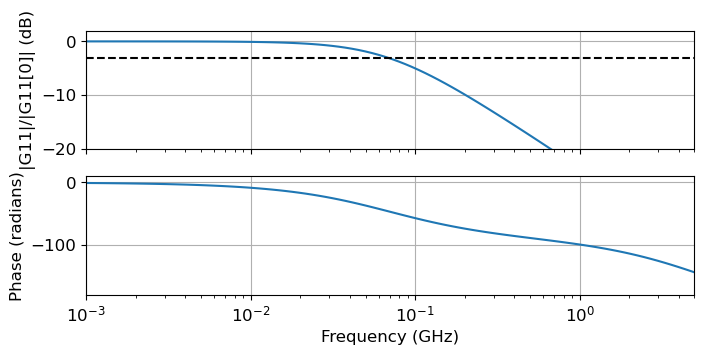

In [13]:
# Produce Bode plots of the results
# Define parameters
my_dpi = 300
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Figure sizes
inchmm = 25.4
nature_single = 89.0 / 25.4
nature_double = 183.0 / 25.4
nature_full = 247.0 / 25.4

# Plot options
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(nature_double,nature_single),sharex=True)

f_min = abs(s[0])
plot_f_max = 5 # GHz

ax1.plot(abs(s),mag_G11_dB)
ax1.plot([f_min,plot_f_max],[-3,-3],'k--')
ax1.grid('True')
ax1.set_xscale('log')
#ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('|G11|/|G11[0]| (dB)')
ax1.set_xlim(f_min,plot_f_max)
ax1.set_ylim(-20,2)

ax2.plot(abs(s),arg_G11*180/np.pi)
ax2.grid('True')
#ax2.set_xscale('log')
ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel('Phase (radians)')
ax2.set_ylim(-180,10)

plt.tight_layout()
#plt.legend()
#plt.savefig(figname+'.eps',bbox_inhces='tight')
#plt.savefig(figname+'.png',dpi=my_dpi)
#plt.savefig(figname+'.svg')
plt.show()

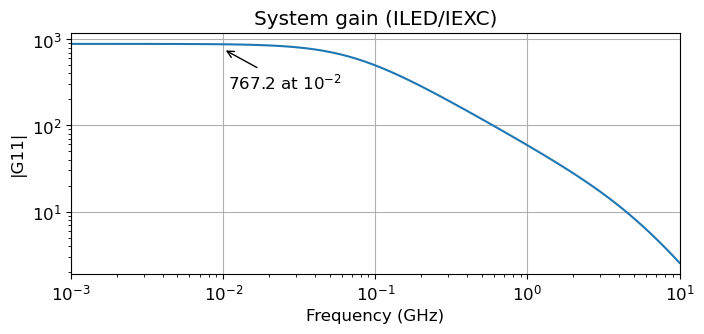

In [14]:
# Plot the system gain function 
fig, ax = plt.subplots(figsize=(nature_double,nature_single))

f_min = abs(s[0])
plot_f_max = 10 # GHz

ax.plot(abs(s),np.absolute(G11))
#ax.plot([f_min,plot_f_max],[-3,-3],'k--')
ax.grid('True')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('|G11|')
ax.set_xlim(f_min,plot_f_max)
#ax.set_ylim(-20,2)
ax.set_title('System gain (ILED/IEXC)')

# Show value at 10^-2 GHz
x = np.array([1e-2])
y, _ = physics.gain(x,eigvals,gammas,capacitances)

ax.annotate(f'{y[0].real : .1f} at '+r'$10^{-2}$', (x,y.real), 
            xytext=(x, y.real-500),
            arrowprops=dict(arrowstyle='->'))



plt.tight_layout()
plt.savefig('system_gain.png',dpi=300)
plt.show()

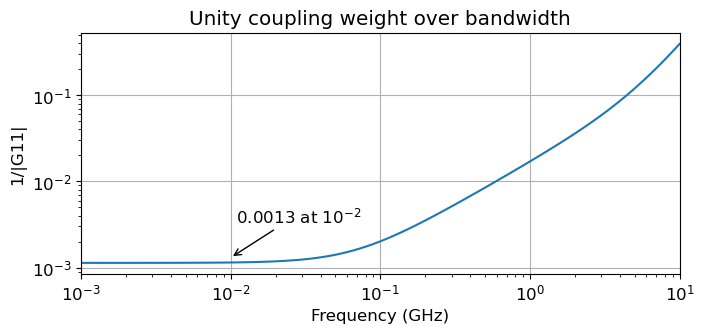

In [15]:
# Plot the inverse gain function to get a value for the unity coupling weight
fig, ax = plt.subplots(figsize=(nature_double,nature_single))

f_min = abs(s[0])
plot_f_max = 10 # GHz

ax.plot(abs(s),np.absolute(G11)**-1)
#ax.plot([f_min,plot_f_max],[-3,-3],'k--')
ax.grid('True')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('1/|G11|')
ax.set_xlim(f_min,plot_f_max)
#ax.set_ylim(-20,2)
ax.set_title('Unity coupling weight over bandwidth')

# Show value at 10^-2 GHz
ax.annotate(f'{y[0].real**-1 : .4f} at '+r'$10^{-2}$', (x,y.real**-1), 
            xytext=(x, y.real**-1+0.002),
            arrowprops=dict(arrowstyle='->'))


plt.tight_layout()
plt.savefig('unity_coeff.png',dpi=300)
plt.show()

In [16]:
# Let's try and retrieve the unity coupling coefficient automatically
unity_coeff = physics.unity_coupling_coefficient()
print(f'We found unity_coeff={unity_coeff :.4f}')

We found unity_coeff=0.0012


#### Comments on these set of bandwidth plots
I have found that the gain is not dependent on the value of Cstore but instead very sensitive to Rstore. There seems to be something that cancels the influence of Cstore on the gain but I am not sure at the moment. Perhaps it's in another parameter range. 
However, the Rstore drastically tunes the system in terms of bandwidth and gain, telling us that we need a larger Rstore to have a larger gain. This is reasonable, as this gives us time to build up charges on Vgate and cause a larger impact on the FET. The minimum weight can thus give us a direct requirement on the Rstore parameter and how large the time-scales need to be in order to send information through the network.